In [1]:
import opensmile 
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import svm
from pprint import pprint
from tqdm import tqdm
base_path = "/home/ubuntu/"

## Utility Functions:

In [2]:
def generate_confusion_matrix(y_test, yhat_test):
    
    #generate confusion matrix
    cm = confusion_matrix(y_test, yhat_test)

    #plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia_r)
    classNames = ['Real','Fake']
    plt.title('Real vs Fake Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [3]:
def generate_ROC_curve(model, y_test, X_test):
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f\n' % (lr_auc))
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [4]:
def run_model_on_test_data(model, X_train, X_test, y_train, y_test, feature_index):
    
    #fit model
    model.fit(X_train[feature_index], y_train)
    
    #predict on held out test data
    yhat_train = model.predict(X_train[feature_index])
    yhat_test = model.predict(X_test[feature_index])
    
    #compute accuracy 
    accuracy_train = accuracy_score(y_train, yhat_train)
    accuracy_test = accuracy_score(y_test, yhat_test)
    
    #print
    print('<---- Train and Test Accuracy ---->\n')
    print('Logistic accuracy train = %.3f' % (accuracy_train*100))
    print('Logistic accuracy test = %.3f' % (accuracy_test*100))
    
    print('\n<---- Classification Report ---->\n')
    print(classification_report(y_test, yhat_test))
    
    print('\n<---- Confusion Matrix ---->\n')
    generate_confusion_matrix(y_test, yhat_test)
    
    print('\n<---- ROC-AUC ---->\n')
    generate_ROC_curve(model, y_test, X_test[feature_index]) 

## Importing 11labs data

In [5]:
biden_real_44k = base_path + 'data/world-leaders-dataset/WavFiles/biden_wav_audio/44KHz'
biden_real_16k = base_path + 'data/world-leaders-dataset/WavFiles/biden_wav_audio/16KHz'
biden_fake_44k = base_path + 'data/world-leaders-dataset/11LabsDeepFakes/44Khz'
biden_fake_16k = base_path + 'data/world-leaders-dataset/11LabsDeepFakes/16Khz'

In [6]:
def get_path_list(folder_path):
    
    path_list = os.listdir(folder_path)
    path_list = [p for p in path_list if ".wav" in p]
    path_list = [os.path.join(folder_path,p) for p in path_list]
    
    return path_list

In [7]:
def generate_smile_df(folder_path, smile_object):
    
    path_list = get_path_list(folder_path)
    
    smile_df = pd.DataFrame()
    
    print("\nGenerating openSMILE features\n")
    
    for i in tqdm(range(len(path_list))):
        df = smile_object.process_file(path_list[i]).reset_index()
        
        duration = df['end'] - df['start']
        duration = duration.astype('timedelta64[ms]')/1000
        df.insert(loc=1, column='duration(seconds)', value=duration)
        
        df = df.rename(columns={'file':'path'})
        
        file = df.path.apply(lambda x:x.split('/')[-1])
        df.insert(loc=1, column='file', value=file)
        
        df.drop(columns=['start', 'end'], inplace=True)
        
        smile_df = pd.concat([smile_df, df])
    
    return smile_df

In [8]:
smile_functionals_ComParE = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals)

In [9]:
cellEnabled = 0
#cellEnabled = 1

savefile_16k = base_path + 'testing-code/opensmile-feature-importance/smile_dfs/' + '0319-SmileFeats-JB_16k.csv'
savefile_44k = base_path + 'testing-code/opensmile-feature-importance/smile_dfs/' + '0319-SmileFeats-JB_44k.csv'

if cellEnabled:

    real_df_16k = generate_smile_df(biden_real_16k, smile_functionals_ComParE)
    real_df_16k.insert(loc=3, column='fake', value=0)

    fake_df_16k = generate_smile_df(biden_fake_16k, smile_functionals_ComParE)
    fake_df_16k.insert(loc=3, column='fake', value=1)

    df_16k = pd.concat([real_df_16k, fake_df_16k]).reset_index(drop=True)
    df_16k.to_csv(savefile_16k, index=False)
    print("\nsaved to {}\n".format(savefile_16k)) 

    real_df_44k = generate_smile_df(biden_real_44k, smile_functionals_ComParE)
    real_df_44k.insert(loc=3, column='fake', value=0)

    fake_df_44k = generate_smile_df(biden_fake_44k, smile_functionals_ComParE)
    fake_df_44k.insert(loc=3, column='fake', value=1)

    df_44k = pd.concat([real_df_44k, fake_df_44k]).reset_index(drop=True)
    df_44k.to_csv(savefile_44k, index=False)
    print("\nsaved to {}\n".format(savefile_44k))
    
if not cellEnabled:
    
    df_16k = pd.read_csv(savefile_16k)
    df_44k = pd.read_csv(savefile_44k)

In [10]:
df_44k.columns

Index(['path', 'file', 'duration(seconds)', 'fake',
       'audspec_lengthL1norm_sma_range', 'audspec_lengthL1norm_sma_maxPos',
       'audspec_lengthL1norm_sma_minPos', 'audspec_lengthL1norm_sma_quartile1',
       'audspec_lengthL1norm_sma_quartile2',
       'audspec_lengthL1norm_sma_quartile3',
       ...
       'mfcc_sma_de[14]_peakRangeAbs', 'mfcc_sma_de[14]_peakRangeRel',
       'mfcc_sma_de[14]_peakMeanAbs', 'mfcc_sma_de[14]_peakMeanMeanDist',
       'mfcc_sma_de[14]_peakMeanRel', 'mfcc_sma_de[14]_minRangeRel',
       'mfcc_sma_de[14]_meanRisingSlope', 'mfcc_sma_de[14]_stddevRisingSlope',
       'mfcc_sma_de[14]_meanFallingSlope',
       'mfcc_sma_de[14]_stddevFallingSlope'],
      dtype='object', length=6377)

## Train-Dev-Test Split:

In [11]:
def process_data(df):
    
    train_df, test_df = train_test_split(df, test_size=0.1, shuffle=True, random_state=45)
    train_df, dev_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=45)
    
    exp_data_scaler = StandardScaler()
    train_df.iloc[:,4:] = exp_data_scaler.fit_transform(train_df.iloc[:,4:])
    dev_df.iloc[:,4:] = exp_data_scaler.transform(dev_df.iloc[:,4:])
    test_df.iloc[:,4:] = exp_data_scaler.transform(test_df.iloc[:,4:])
    
    X_train = train_df.drop(columns=['path', 'file', 'duration(seconds)', 'fake']).copy()
    y_train = train_df['fake'].copy()

    X_dev = dev_df.drop(columns=['path', 'file', 'duration(seconds)', 'fake'])
    y_dev = dev_df['fake'].copy()

    X_test = test_df.drop(columns=['path', 'file', 'duration(seconds)', 'fake'])
    y_test = test_df['fake'].copy()
    
    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [12]:
X_train_16k, y_train_16k, X_dev_16k, y_dev_16k, X_test_16k, y_test_16k = process_data(df_16k)
X_train_44k, y_train_44k, X_dev_44k, y_dev_44k, X_test_44k, y_test_44k = process_data(df_44k)

## Brute-Force feature selection:

In [13]:
def run_bflr(X_train, y_train, X_dev, y_dev):
    
    train_accuracies = []
    dev_accuracies = []
    
    for i in tqdm(range(6373)):
        
        model_lr = LogisticRegression()
        model_lr.fit(X_train.iloc[:,i].to_numpy().reshape(-1, 1), y_train)
        y_hat_train = model_lr.predict(X_train.iloc[:,i].to_numpy().reshape(-1, 1))
        y_hat_dev = model_lr.predict(X_dev.iloc[:,i].to_numpy().reshape(-1, 1))
        train_accuracy = accuracy_score(y_train, y_hat_train)
        train_accuracies.append(train_accuracy)        
        dev_accuracy = accuracy_score(y_dev, y_hat_dev)
        dev_accuracies.append(dev_accuracy)
    
    print("\nAverage train accuracy: {}".format(np.mean(train_accuracies)))
    print("Average dev accuracy: {}\n".format(np.mean(dev_accuracies)))
    
    return dev_accuracies

In [14]:
def run_bfsvm(X_train, y_train, X_dev, y_dev):
    
    train_accuracies = []
    dev_accuracies = []
    
    for i in tqdm(range(6373)):
        
        model_svm = svm.SVC(probability=True)
        model_svm.fit(X_train.iloc[:,i].to_numpy().reshape(-1, 1), y_train)
        y_hat_train = model_svm.predict(X_train.iloc[:,i].to_numpy().reshape(-1, 1))
        y_hat_dev = model_svm.predict(X_dev.iloc[:,i].to_numpy().reshape(-1, 1))
        train_accuracy = accuracy_score(y_train, y_hat_train)
        train_accuracies.append(train_accuracy)        
        dev_accuracy = accuracy_score(y_dev, y_hat_dev)
        dev_accuracies.append(dev_accuracy)
    
    print("\nAverage train accuracy: {}".format(np.mean(train_accuracies)))
    print("Average dev accuracy: {}\n".format(np.mean(dev_accuracies)))
    
    return dev_accuracies

In [15]:
features = df_16k.columns.to_list()[4:]
bruteforce_df = pd.DataFrame(features, columns=['features'])
bruteforce_df['dev_16k_accuracies_lr'] = run_bflr(X_train_16k, y_train_16k, X_dev_16k, y_dev_16k)
bruteforce_df['dev_44k_accuracies_lr'] = run_bflr(X_train_44k, y_train_44k, X_dev_44k, y_dev_44k)
bruteforce_df['dev_16k_accuracies_svm'] = run_bfsvm(X_train_16k, y_train_16k, X_dev_16k, y_dev_16k)
bruteforce_df['dev_44k_accuracies_svm'] = run_bfsvm(X_train_44k, y_train_44k, X_dev_44k, y_dev_44k)

100%|██████████| 6373/6373 [00:11<00:00, 577.58it/s]



Average train accuracy: 0.6238356108310193
Average dev accuracy: 0.6180923527542075



100%|██████████| 6373/6373 [00:11<00:00, 576.22it/s]



Average train accuracy: 0.619171459304084
Average dev accuracy: 0.6152800074030264



100%|██████████| 6373/6373 [02:27<00:00, 43.33it/s]



Average train accuracy: 0.6653431482909101
Average dev accuracy: 0.6635606142902549



100%|██████████| 6373/6373 [02:30<00:00, 42.34it/s]


Average train accuracy: 0.6607772373032063
Average dev accuracy: 0.6583302152108051



In [20]:
bruteforce_df['mean_dev_accuracies_lr'] = bruteforce_df[['dev_16k_accuracies_lr','dev_44k_accuracies_lr']].mean(axis=1)
bruteforce_df['mean_dev_accuracies_svm'] = bruteforce_df[['dev_16k_accuracies_svm','dev_44k_accuracies_svm']].mean(axis=1)
bruteforce_df['mean_dev_accuracies_all'] = bruteforce_df.iloc[:,1:].mean(axis=1)
bruteforce_df.head()

,features,dev_16k_accuracies_lr,dev_44k_accuracies_lr,dev_16k_accuracies_svm,dev_44k_accuracies_svm,mean_dev_accuracies_lr,mean_dev_accuracies_svm,mean_dev_accuracies_all
0,audspec_lengthL1norm_sma_range,0.666667,0.666667,0.641026,0.641026,0.666667,0.641026,0.653846
1,audspec_lengthL1norm_sma_maxPos,0.692308,0.615385,0.692308,0.692308,0.653846,0.692308,0.673077
2,audspec_lengthL1norm_sma_minPos,0.923077,0.923077,0.923077,0.923077,0.923077,0.923077,0.923077
3,audspec_lengthL1norm_sma_quartile1,0.717949,0.717949,0.820513,0.820513,0.717949,0.820513,0.769231
4,audspec_lengthL1norm_sma_quartile2,0.794872,0.794872,0.897436,0.897436,0.794872,0.897436,0.846154


#### Results

In [51]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.95).all(axis=1)].sort_values(by='mean_dev_accuracies_lr', ascending=False)

,features,dev_16k_accuracies_lr,dev_44k_accuracies_lr,dev_16k_accuracies_svm,dev_44k_accuracies_svm,mean_dev_accuracies_lr,mean_dev_accuracies_svm,mean_dev_accuracies_all
1545,mfcc_sma[1]_lpc0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1823,mfcc_sma[10]_lpgain,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2645,audSpec_Rfilt_sma_de[22]_percentile99.0,0.974359,1.000000,0.974359,0.974359,0.987179,0.974359,0.980769
3529,mfcc_sma_de[10]_lpc0,0.974359,1.000000,0.974359,1.000000,0.987179,0.987179,0.987179
1824,mfcc_sma[10]_lpc0,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
1833,mfcc_sma[11]_quartile2,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
2644,audSpec_Rfilt_sma_de[22]_percentile1.0,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
2646,audSpec_Rfilt_sma_de[22]_pctlrange0-1,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
2647,audSpec_Rfilt_sma_de[22]_stddev,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
3235,mfcc_sma_de[1]_pctlrange0-1,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359


In [25]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.95).all(axis=1)].sort_values(by='mean_dev_accuracies_svm', ascending=False)

,features,dev_16k_accuracies_lr,dev_44k_accuracies_lr,dev_16k_accuracies_svm,dev_44k_accuracies_svm,mean_dev_accuracies_lr,mean_dev_accuracies_svm,mean_dev_accuracies_all
1545,mfcc_sma[1]_lpc0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1823,mfcc_sma[10]_lpgain,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3529,mfcc_sma_de[10]_lpc0,0.974359,1.000000,0.974359,1.000000,0.987179,0.987179,0.987179
1824,mfcc_sma[10]_lpc0,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
1833,mfcc_sma[11]_quartile2,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
2644,audSpec_Rfilt_sma_de[22]_percentile1.0,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
2645,audSpec_Rfilt_sma_de[22]_percentile99.0,0.974359,1.000000,0.974359,0.974359,0.987179,0.974359,0.980769
2646,audSpec_Rfilt_sma_de[22]_pctlrange0-1,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
2647,audSpec_Rfilt_sma_de[22]_stddev,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
3235,mfcc_sma_de[1]_pctlrange0-1,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359


In [30]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.95).all(axis=1)].sort_values(by='mean_dev_accuracies_all', ascending=False)

,features,dev_16k_accuracies_lr,dev_44k_accuracies_lr,dev_16k_accuracies_svm,dev_44k_accuracies_svm,mean_dev_accuracies_lr,mean_dev_accuracies_svm,mean_dev_accuracies_all
1545,mfcc_sma[1]_lpc0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1823,mfcc_sma[10]_lpgain,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3529,mfcc_sma_de[10]_lpc0,0.974359,1.000000,0.974359,1.000000,0.987179,0.987179,0.987179
2645,audSpec_Rfilt_sma_de[22]_percentile99.0,0.974359,1.000000,0.974359,0.974359,0.987179,0.974359,0.980769
1824,mfcc_sma[10]_lpc0,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
1833,mfcc_sma[11]_quartile2,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
2644,audSpec_Rfilt_sma_de[22]_percentile1.0,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
2646,audSpec_Rfilt_sma_de[22]_pctlrange0-1,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
2647,audSpec_Rfilt_sma_de[22]_stddev,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359
3235,mfcc_sma_de[1]_pctlrange0-1,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359,0.974359


In [29]:
bruteforce_df[(bruteforce_df["features"].str.contains("zcr")) & (bruteforce_df.iloc[:,1:] > 0.95).any(axis=1)].sort_values(by='dev_16k_accuracies_lr', ascending=False)

,features,dev_16k_accuracies_lr,dev_44k_accuracies_lr,dev_16k_accuracies_svm,dev_44k_accuracies_svm,mean_dev_accuracies_lr,mean_dev_accuracies_svm,mean_dev_accuracies_all
5546,pcm_zcr_sma_de_meanFallingSlope,1.000000,0.948718,1.000000,0.974359,0.974359,0.987179,0.980769
242,pcm_zcr_sma_de_lpgain,0.923077,0.974359,0.897436,0.974359,0.948718,0.935897,0.942308
247,pcm_zcr_sma_de_lpc4,0.897436,0.974359,0.846154,0.948718,0.935897,0.897436,0.916667
243,pcm_zcr_sma_de_lpc0,0.871795,0.974359,0.871795,0.974359,0.923077,0.923077,0.923077
5543,pcm_zcr_sma_de_minRangeRel,0.820513,0.974359,0.846154,0.974359,0.897436,0.910256,0.903846


In [40]:
selected_features = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.95).all(axis=1)]['features']
selected_features

1545                           mfcc_sma[1]_lpc0
1823                        mfcc_sma[10]_lpgain
1824                          mfcc_sma[10]_lpc0
1833                     mfcc_sma[11]_quartile2
2644     audSpec_Rfilt_sma_de[22]_percentile1.0
2645    audSpec_Rfilt_sma_de[22]_percentile99.0
2646      audSpec_Rfilt_sma_de[22]_pctlrange0-1
2647            audSpec_Rfilt_sma_de[22]_stddev
3235                mfcc_sma_de[1]_pctlrange0-1
3529                       mfcc_sma_de[10]_lpc0
5177                mfcc_sma[1]_meanRisingSlope
5396                         mfcc_sma[11]_amean
5880            audSpec_Rfilt_sma_de[22]_rqmean
Name: features, dtype: object

### Performance on held out test data

In [32]:
#data concatenation
X_train_final_16k = pd.concat([X_train_16k, X_dev_16k])
y_train_final_16k = pd.concat([y_train_16k, y_dev_16k])

X_train_final_44k = pd.concat([X_train_44k, X_dev_44k])
y_train_final_44k = pd.concat([y_train_44k, y_dev_44k])

X_train_final = pd.concat([X_train_44k, X_dev_44k, X_train_16k, X_dev_16k])
y_train_final = pd.concat([y_train_44k, y_dev_44k, y_train_16k, y_dev_16k])

X_test_final = pd.concat([X_test_44k, X_test_16k])
y_test_final = pd.concat([y_test_44k, y_test_16k])

#### Model 1

In [33]:
#select features identified from brute force
feature_index_1 = df_16k.columns.intersection(['mfcc_sma[10]_lpgain', 'mfcc_sma[1]_lpc0'])

<---- Train and Test Accuracy ---->

Logistic accuracy train = 98.958
Logistic accuracy test = 97.674

<---- Classification Report ---->

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.96      0.98        24

    accuracy                           0.98        43
   macro avg       0.97      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43


<---- Confusion Matrix ---->



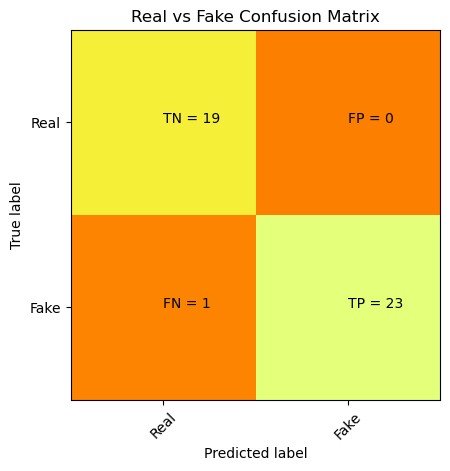


<---- ROC-AUC ---->

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.993



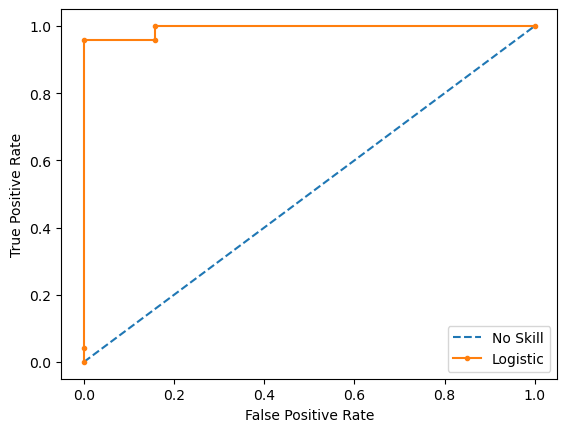

In [34]:
#run model on 16k
model_svm_16k = svm.SVC(probability=True)
run_model_on_test_data(model_svm_16k, X_train_final_16k, X_test_16k, y_train_final_16k, y_test_16k, feature_index_1)

<---- Train and Test Accuracy ---->

Logistic accuracy train = 98.438
Logistic accuracy test = 97.674

<---- Classification Report ---->

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.96      0.98        24

    accuracy                           0.98        43
   macro avg       0.97      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43


<---- Confusion Matrix ---->



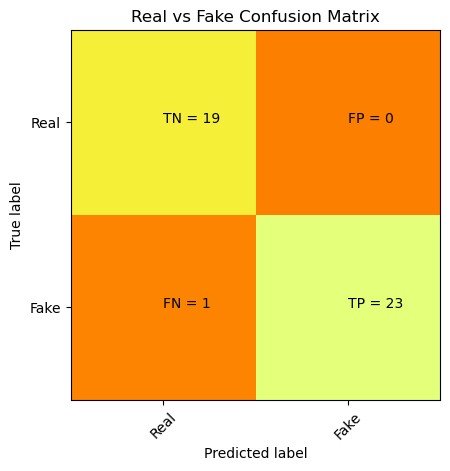


<---- ROC-AUC ---->

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.998



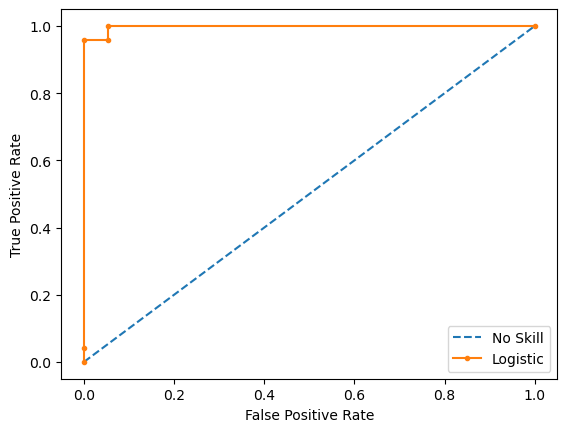

In [35]:
#run model on 44k
model_svm_44k = svm.SVC(probability=True)
run_model_on_test_data(model_svm_44k, X_train_final_44k, X_test_44k, y_train_final_44k, y_test_44k, feature_index_1)

<---- Train and Test Accuracy ---->

Logistic accuracy train = 99.089
Logistic accuracy test = 97.674

<---- Classification Report ---->

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        38
           1       1.00      0.96      0.98        48

    accuracy                           0.98        86
   macro avg       0.97      0.98      0.98        86
weighted avg       0.98      0.98      0.98        86


<---- Confusion Matrix ---->



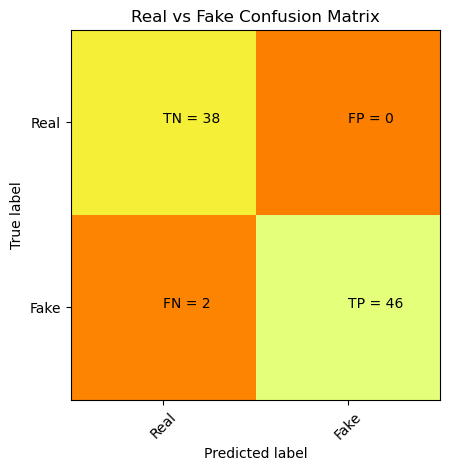


<---- ROC-AUC ---->

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.994



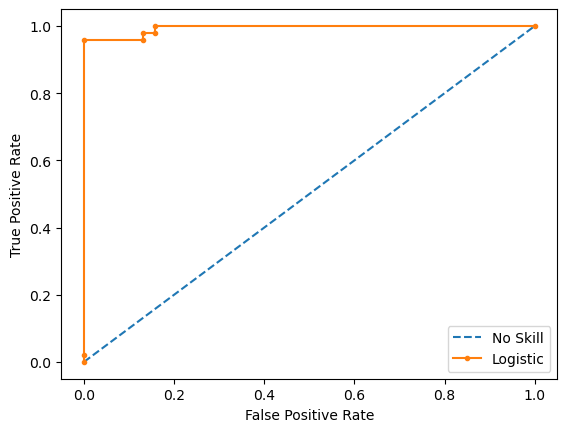

In [36]:
#run model on both together
model_svm_combined = svm.SVC(probability=True)
run_model_on_test_data(model_svm_combined, X_train_final, X_test_final, y_train_final, y_test_final, feature_index_1)

#### Model 2

In [41]:
#select features identified from brute force
feature_index_2 = df_16k.columns.intersection(selected_features)
feature_index_2

Index(['mfcc_sma[1]_lpc0', 'mfcc_sma[10]_lpgain', 'mfcc_sma[10]_lpc0',
       'mfcc_sma[11]_quartile2', 'audSpec_Rfilt_sma_de[22]_percentile1.0',
       'audSpec_Rfilt_sma_de[22]_percentile99.0',
       'audSpec_Rfilt_sma_de[22]_pctlrange0-1',
       'audSpec_Rfilt_sma_de[22]_stddev', 'mfcc_sma_de[1]_pctlrange0-1',
       'mfcc_sma_de[10]_lpc0', 'mfcc_sma[1]_meanRisingSlope',
       'mfcc_sma[11]_amean', 'audSpec_Rfilt_sma_de[22]_rqmean'],
      dtype='object')

<---- Train and Test Accuracy ---->

Logistic accuracy train = 100.000
Logistic accuracy test = 100.000

<---- Classification Report ---->

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        24

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43


<---- Confusion Matrix ---->



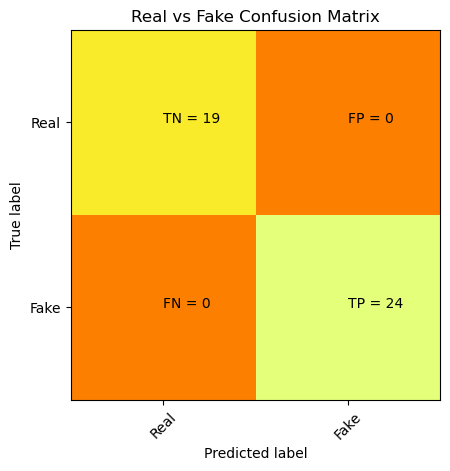


<---- ROC-AUC ---->

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000



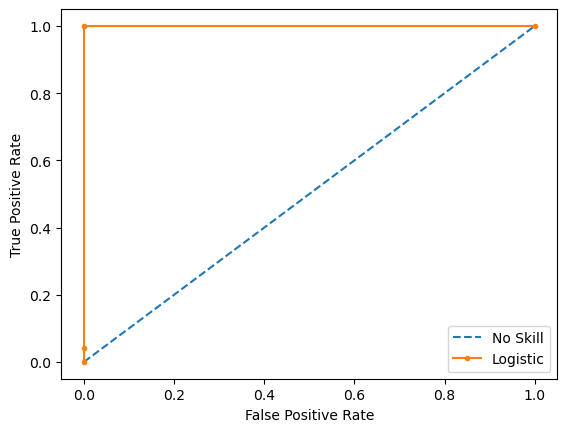

In [42]:
#run model on 16k
model_svm_16k = svm.SVC(probability=True)
run_model_on_test_data(model_svm_16k, X_train_final_16k, X_test_16k, y_train_final_16k, y_test_16k, feature_index_2)

<---- Train and Test Accuracy ---->

Logistic accuracy train = 100.000
Logistic accuracy test = 100.000

<---- Classification Report ---->

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        24

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43


<---- Confusion Matrix ---->



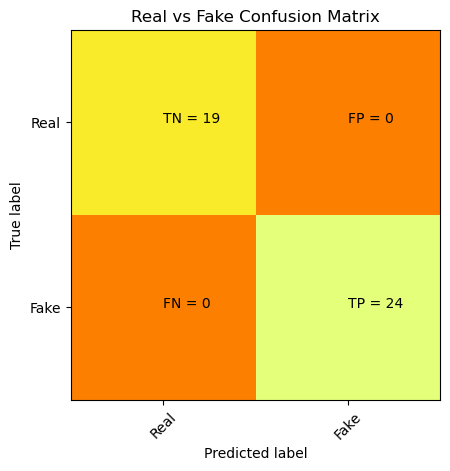


<---- ROC-AUC ---->

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000



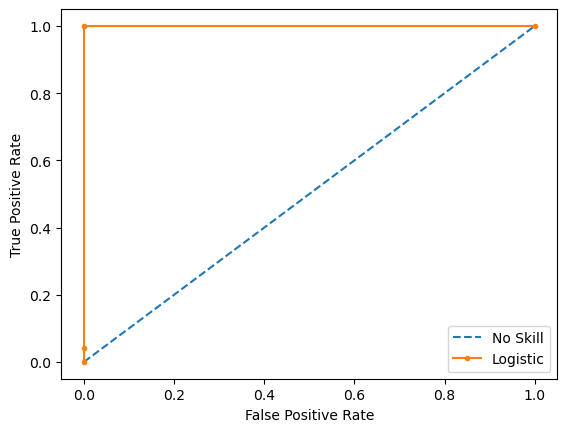

In [43]:
#run model on 44k
model_svm_44k = svm.SVC(probability=True)
run_model_on_test_data(model_svm_44k, X_train_final_44k, X_test_44k, y_train_final_44k, y_test_44k, feature_index_2)

<---- Train and Test Accuracy ---->

Logistic accuracy train = 100.000
Logistic accuracy test = 100.000

<---- Classification Report ---->

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        48

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86


<---- Confusion Matrix ---->



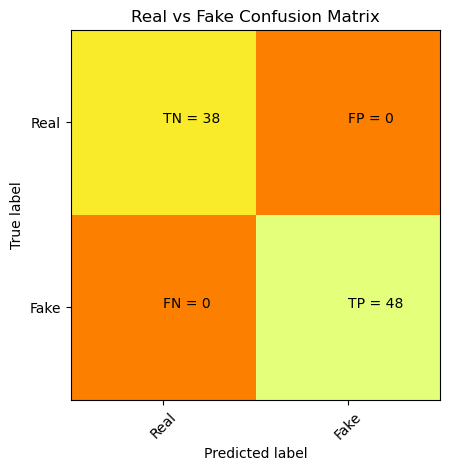


<---- ROC-AUC ---->

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000



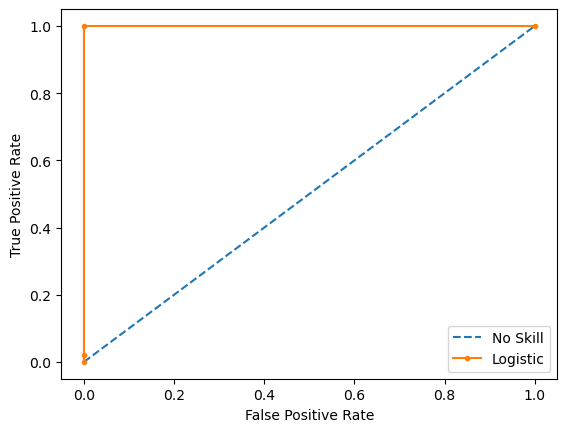

In [44]:
#run model on both together
model_svm_combined = svm.SVC(probability=True)
run_model_on_test_data(model_svm_combined, X_train_final, X_test_final, y_train_final, y_test_final, feature_index_2)

<---- Train and Test Accuracy ---->

Logistic accuracy train = 100.000
Logistic accuracy test = 100.000

<---- Classification Report ---->

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        48

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86


<---- Confusion Matrix ---->



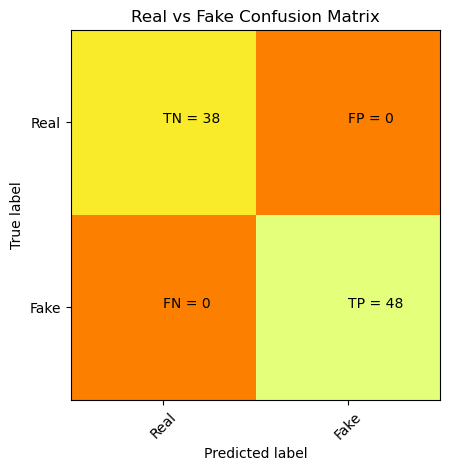


<---- ROC-AUC ---->

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000



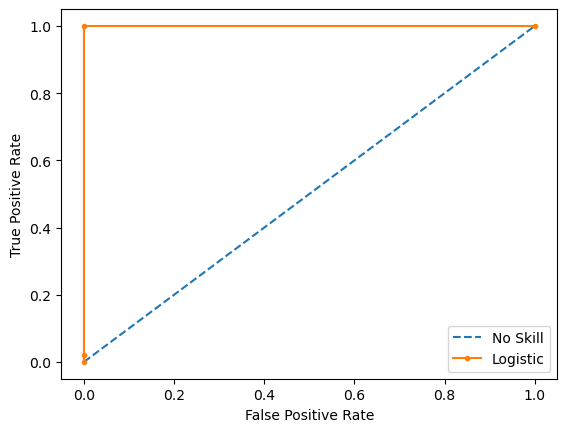

In [46]:
#run model on both together
model_lr_combined = LogisticRegression()
run_model_on_test_data(model_lr_combined, X_train_final, X_test_final, y_train_final, y_test_final, feature_index_2)

# Appendix (WIP)

In [49]:
def run_bflr_2(X_train, y_train, X_dev, y_dev, features):
    
    train_accuracies = []
    dev_accuracies = []
    
    for i in tqdm(range(len(features))):
        
        model_lr = LogisticRegression()
        model_lr.fit(X_train[features[i]].iloc[:,i].to_numpy().reshape(-1, 1), y_train)
        y_hat_train = model_lr.predict(X_train[features[i]].iloc[:,i].to_numpy().reshape(-1, 1))
        y_hat_dev = model_lr.predict(X_dev[features[i]].iloc[:,i].to_numpy().reshape(-1, 1))
        train_accuracy = accuracy_score(y_train, y_hat_train)
        train_accuracies.append(train_accuracy)        
        dev_accuracy = accuracy_score(y_dev, y_hat_dev)
        dev_accuracies.append(dev_accuracy)
    
    print("\nAverage train accuracy: {}".format(np.mean(train_accuracies)))
    print("Average dev accuracy: {}\n".format(np.mean(dev_accuracies)))
    
    return dev_accuracies